# Twitter Consume Reporter Argentina

Ejemplo de recolección de información desde cammesa y su publicacion en twitter.

In [1]:
#hide
import os,sys,glob,shutil
import zipfile
from tweet_informer_lib import wget,pd,datetime
from tweet_informer_lib import cammesa_consume_reader
from tweet_informer_lib import json,tweepy,reduce,plt,gpd,unidecode,make_cammesa_url_v2
from IPython.display import display

#
jnb=True # To display html
local_config=True # to use local credentials files (True) else sys.args input

### Pre-Procesamiento

Las url de cammesa dependen de la provincia o sector a bajar, eso lo gestionamos via un diccionario

In [2]:
#hide
pd_cfg=pd.read_csv('cfg/csv_cfg_provincias.csv',index_col=0)
prov_dict=pd_cfg.T.to_dict()

In [3]:
#hide
with zipfile.ZipFile('cfg/provincia_geojson.zip', 'r') as zip_ref:
    zip_ref.extractall('cfg')
    df_prov=gpd.read_file('cfg/provincia.geojson')
    df_prov.NAM=df_prov.NAM.apply(unidecode.unidecode)
    os.remove('cfg/provincia.geojson')

In [4]:
#hide_input
url_dict={}
for opt in prov_dict:
    url_dict.update({opt:{}})
    provincia,url_case=prov_dict[opt]['Total'],prov_dict[opt]['url']
    make_cammesa_url_v2('provincia',provincia,url_dict[opt],url_case)

url_dict

{'La Rioja': {'provincia': 'https://aplic.cammesa.com/complemento-portal/descargar?type=csv&value=ChtDem_0129.xml&header=datosDemandas'},
 'Santiago del Estero': {'provincia': 'https://aplic.cammesa.com/complemento-portal/descargar?type=csv&value=ChtDem_0127.xml&header=datosDemandas'},
 'Tucuman': {'provincia': 'https://aplic.cammesa.com/complemento-portal/descargar?type=csv&value=ChtDem_0126.xml&header=datosDemandas'},
 'Salta': {'provincia': 'https://aplic.cammesa.com/complemento-portal/descargar?type=csv&value=ChtDem_0125.xml&header=datosDemandas'},
 'Jujuy': {'provincia': 'https://aplic.cammesa.com/complemento-portal/descargar?type=csv&value=ChtDem_0124.xml&header=datosDemandas'},
 'Catamarca': {'provincia': 'https://aplic.cammesa.com/complemento-portal/descargar?type=csv&value=ChtDem_0156.xml&header=datosDemandas'},
 'Cordoba': {'provincia': 'https://aplic.cammesa.com/complemento-portal/descargar?type=csv&value=ChtDem_0145.xml&header=datosDemandas'},
 'San Luis': {'provincia': 'ht

In [5]:
#hide
## make some temporal dirs
tmp='tmp_mapa'
arxive='arxive'
for folder in [arxive,tmp]:
    os.makedirs(folder,exist_ok=True)

descargamos los archivos...

In [6]:
#hide_input
csv_dict={}
req_time=datetime.datetime.now().strftime('%Y%m%d%H%M%S')
for p in url_dict:
    csv_dict.update({p:{}})
    for key in url_dict[p]:
        filename=os.path.join(tmp,p+'_'+key+'.csv')
        filesaved = wget.download(url_dict[p][key],out=filename)
        csv_dict[p].update({key:filesaved})

csv_dict

{'La Rioja': {'provincia': 'tmp_mapa/La Rioja_provincia.csv'},
 'Santiago del Estero': {'provincia': 'tmp_mapa/Santiago del Estero_provincia.csv'},
 'Tucuman': {'provincia': 'tmp_mapa/Tucuman_provincia.csv'},
 'Salta': {'provincia': 'tmp_mapa/Salta_provincia.csv'},
 'Jujuy': {'provincia': 'tmp_mapa/Jujuy_provincia.csv'},
 'Catamarca': {'provincia': 'tmp_mapa/Catamarca_provincia.csv'},
 'Cordoba': {'provincia': 'tmp_mapa/Cordoba_provincia.csv'},
 'San Luis': {'provincia': 'tmp_mapa/San Luis_provincia.csv'},
 'Corrientes': {'provincia': 'tmp_mapa/Corrientes_provincia.csv'},
 'Chaco': {'provincia': 'tmp_mapa/Chaco_provincia.csv'},
 'Formosa': {'provincia': 'tmp_mapa/Formosa_provincia.csv'},
 'Misiones': {'provincia': 'tmp_mapa/Misiones_provincia.csv'},
 'Santa Fe': {'provincia': 'tmp_mapa/Santa Fe_provincia.csv'},
 'Entre Rios': {'provincia': 'tmp_mapa/Entre Rios_provincia.csv'},
 'Mendoza': {'provincia': 'tmp_mapa/Mendoza_provincia.csv'},
 'San Juan': {'provincia': 'tmp_mapa/San Juan_pro

In [7]:
#hide
csv_=glob.glob(os.path.join(tmp,'*.csv'))
if len(csv_)>0:
    pass
else:
    shutil.rmtree(tmp)
    sys.exit('No CSV files')

### Dataframe procesado

In [8]:
#hide
aux=[]
for p in csv_dict:
    if p in ['Buenos Aires','SADI','GBA']:
        drop=[1,2,3,4]
    else:
        drop=[1,2]
    df=cammesa_consume_reader(csv_dict[p]['provincia'],drop)
    df.columns=[p]
    aux.append(df)
df=reduce(lambda x, y: pd.merge(x, y, left_index=True,right_index=True), aux)
df[df < 0] = 0
df_notna=df.dropna()
#
df_notna=df_notna.dropna()
##
series=df_notna.iloc[-1]
series_time=series.name.strftime('%d-%m-%Y %H:%M:%S')
df_new=pd.DataFrame(df_notna.iloc[-1]).reset_index()
df_new.columns=['NAM','Consumo']
df_new['Consumo_Porc']=df_new['Consumo']/df_notna['SADI'].iloc[-1]*100
df_new['NAM']=df_new['NAM'].apply(lambda x: x if x!='GBA' else 'Ciudad Autonoma de Buenos Aires')

In [9]:
#hide
df_filt=df_prov.merge(df_new,on='NAM')
if len(df_filt)>1:
    pass
else:
    shutil.rmtree(tmp)
    sys.exit('Short Dataframe')

Observamos el data frame procesado

In [10]:
#hide_input
df_filt

,FNA,GNA,NAM,SAG,IN1,geometry,Consumo,Consumo_Porc
0,Provincia de Misiones,Provincia,Misiones,IGN,54,"MULTIPOLYGON (((-54.10906 -25.53982, -54.11194...",267.93,2.101616
1,Provincia de San Luis,Provincia,San Luis,IGN,74,"MULTIPOLYGON (((-67.05547 -31.85605, -67.05000...",167.28,1.312128
2,Provincia de San Juan,Provincia,San Juan,IGN,70,"MULTIPOLYGON (((-67.32964 -32.35883, -67.32964...",194.91,1.528855
3,Provincia de Entre Ríos,Provincia,Entre Rios,IGN,30,"MULTIPOLYGON (((-58.58138 -30.16010, -58.58102...",369.01,2.894478
4,Provincia de Santa Cruz,Provincia,Santa Cruz,IGN,78,"MULTIPOLYGON (((-71.54709 -45.99975, -71.54573...",191.73,1.503911
5,Provincia de Río Negro,Provincia,Rio Negro,IGN,62,"MULTIPOLYGON (((-64.76547 -40.78351, -64.76618...",212.83,1.669417
6,Provincia del Chubut,Provincia,Chubut,IGN,26,"MULTIPOLYGON (((-71.85480 -43.49645, -71.85459...",360.09,2.824510
7,Provincia de Córdoba,Provincia,Cordoba,IGN,14,"MULTIPOLYGON (((-63.87371 -29.62377, -63.86959...",995.12,7.805622
8,Provincia de Mendoza,Provincia,Mendoza,IGN,50,"MULTIPOLYGON (((-69.12570 -32.00283, -69.12296...",634.12,4.973974
9,Provincia de La Rioja,Provincia,La Rioja,IGN,46,"MULTIPOLYGON (((-68.52083 -27.81988, -68.52011...",175.81,1.379036


y generamos el grafico correspondiente que sera utilizado en el tweet

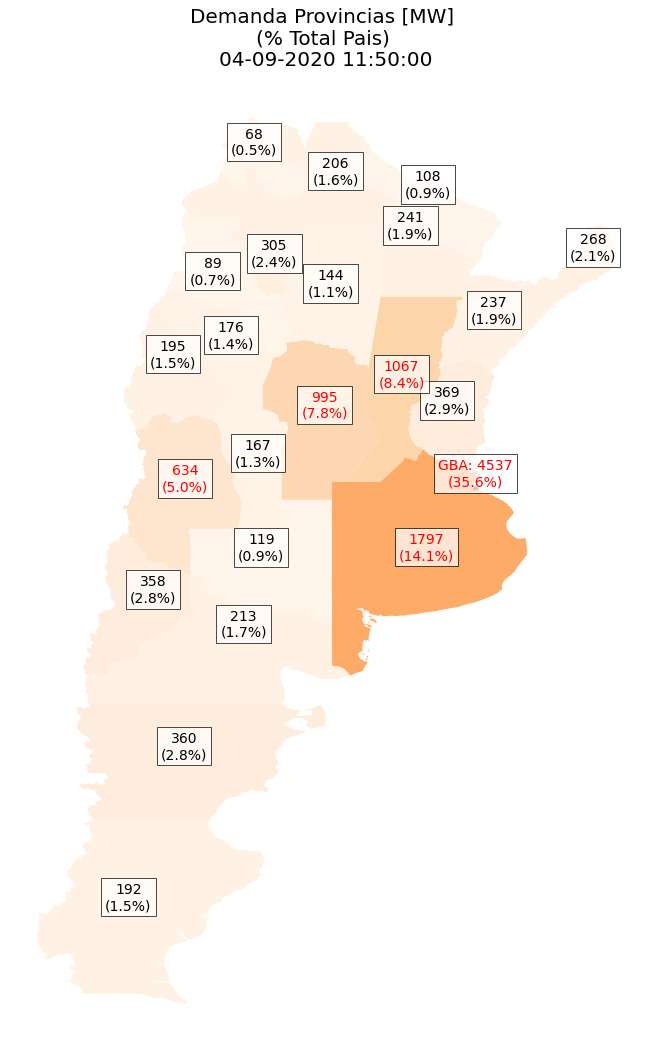

In [11]:
#hide_input
try:
    fig=plt.figure(figsize=(15, 18))
    ax=fig.add_subplot(111)
    df_filt.plot(column='Consumo',cmap='Oranges',ax=ax)
    for p in df_filt.NAM:
        x=df_filt[df_filt.NAM==p].geometry.representative_point().x
        y=df_filt[df_filt.NAM==p].geometry.representative_point().y
        MW_porc=df_filt[df_filt.NAM==p]['Consumo_Porc'].values
        MW=df_filt[df_filt.NAM==p]['Consumo'].values
        if MW_porc[0]>1/22*100:
            c='red'
        else:
            c='black'    
        if p=='Ciudad Autonoma de Buenos Aires':
            fmt='GBA: {:.0f}\n({:.1f}%)'
        else:
            fmt='{:.0f}\n({:.1f}%)'
        ax.text(x,y,fmt.format(MW[0],MW_porc[0]),horizontalalignment='center',verticalalignment='bottom',bbox=dict(facecolor='white', alpha=0.7),fontsize=14,color=c)
        ax.set_title('Demanda Provincias [MW] \n(% Total Pais) \n'+series_time,fontsize=20)
    # save fig
    plt.axis('off')
    figName=os.path.join(tmp,'mapa_consumo.png')
    fig.savefig(figName,transparent=False)
except:
    shutil.rmtree(tmp)
    print('Plot ERROR')
    sys.exit('Plot ERROR')   

### Twitter Side

Cargamos la configuración y generamos el tweet correspondiente y mostramos un ejemplo (puede no corresponder a la imagen generada).

In [12]:
#collapse
try:
    if local_config:
        ## .tweepy.json not available
        config_file = 'cfg/.tweepy.json'
        with open(config_file) as fh:
            config = json.load(fh)
    else:
        # use sys.arg (## .tweepy.json not available)
        config={'consumer_key':sys.argv[1],\
             'consumer_secret':sys.argv[2],\
             'access_token': sys.argv[3],\
             'access_token_secret':sys.argv[4]}
        
    
    auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
    auth.set_access_token(config['access_token'], config['access_token_secret'])
    twitter = tweepy.API(auth)
    tweet ='Demanda Provincias [MW] y % Total Pais'
    image_path =figName
    # to attach the media file 
    status = twitter.update_with_media(image_path, tweet)
except:
    shutil.rmtree(tmp)
    sys.exit('Failed to TWEET')

## src: https://github.com/jupyter/notebook/issues/2790
class Tweet(object):
    def __init__(self, embed_str=None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

In [15]:
#hide_input
if jnb:
    s = ("""<blockquote class="twitter-tweet"><p lang="es" dir="ltr">Demanda Provincias [MW] y % Total Pais <a href="https://t.co/QmQ4dLX0Na">pic.twitter.com/QmQ4dLX0Na</a></p>&mdash; misc reporter (@ReporterMisc) <a href="https://twitter.com/ReporterMisc/status/1248263928779587584?ref_src=twsrc%5Etfw">April 9, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> """)
    ## src: https://github.com/jupyter/notebook/issues/2790
    display(Tweet(s))

In [17]:
#hide
shutil.rmtree(tmp)